In [20]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

import openpyxl
import csv
import pandas as pd
from itertools import islice

In [21]:
# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)
str_labels_true = np.zeros(labels_true.shape, dtype = np.object_)
str_labels_true[np.where(labels_true == 0)]="Jean"
str_labels_true[np.where(labels_true == 1)]="Lola"
str_labels_true[np.where(labels_true == 2)]="Eva"

In [22]:
def read_cells_information(file_path):
    """
    Read file that contains cell positions and create cells centroids x,y position and layer classification
    :param file_path:(str) Path to the file that contains cell positions exported form QuPath
    :return:
        tuple:
            - cells_centroid_x np.array of shape (number of cells, ) of type float
            - cells_centroid_y np.array of shape (number of cells, ) of type float
            - layer_classification
    """
    workbook = openpyxl.Workbook()
    worksheets = workbook.worksheets[0]

    with open(file_path, 'r', encoding="utf-8") as data:
        reader = csv.reader(data, delimiter='\t')
        for row in reader:
            worksheets.append(row)
    data = worksheets.values
    cols = next(data)[1:]
    data = list(data)
    idx = [r[0] for r in data]
    data = (islice(r, 1, None) for r in data)
    df = pd.DataFrame(data, index=idx, columns=cols)
    return df

In [23]:
cell_position_file_path = '../../QuPathProject/layerBoundary/Results/detection.txt'
df = read_cells_information(cell_position_file_path)


In [44]:
labels_true = []
Xs = []
Ys = []
layer_name = 'Layer 2'
layer = df[df["Class"] == layer_name]
Xs.extend(layer['Centroid X µm'].to_numpy(dtype=float) )
Ys.extend(layer['Centroid Y µm'].to_numpy(dtype=float) )
labels_true.extend([layer_name] * len(layer['Centroid X µm'].to_numpy(dtype=float)))
X = np.column_stack((Xs,Ys))

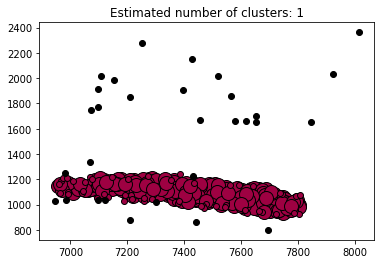

In [46]:
# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=50, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

'''
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))
'''
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

col (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
col [0, 0, 0, 1]


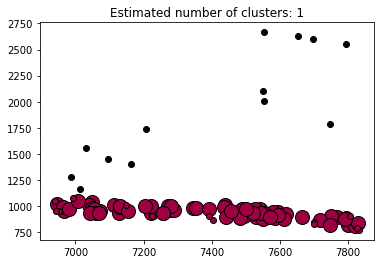